In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

## Cleaning the data

In [2]:
df : pd.DataFrame = pd.read_csv('my_data.csv')

In [3]:
df.head()

,Unnamed: 0,year,make,model,mileage,title,state of origin,engine size,engine type,drivetrain,transmmision type,number of gears,body_style,color,numberg of higlights,number of flaws,price
0,0,1999,Mercedes-Benz,SL600,"52,000",Clean,NJ,6.0L,V12,Rear-wheel drive,Automatic,5-Speed,Convertible,Black,5,3,"$30,500"
1,1,2017,BMW,330i,"43,400",Clean,KS,2.0L,I4,4WD/AWD,Automatic,8-Speed,Wagon,Glacier Silver,6,4,"$41,500"
2,2,2008,MINI,Cooper Clubman,"104,100",Clean,TN,1.6L,I4,Front-wheel drive,Manual,6-Speed,Wagon,Hot Chocolate Metallic,5,11,"$9,969"
3,3,2013,Porsche,Cayenne,"82,400",Clean,CA,4.8L,V8,4WD/AWD,Automatic,8-Speed,SUV/Crossover,Meteor Grey Metallic,4,2,"$29,000"
4,4,2019,Chevrolet,Camaro,"9,500",Clean,NY,6.2L,V8,Rear-wheel drive,Automatic,10-Speed,Coupe,Riverside Blue Metallic,4,3,"$60,333"


In [4]:
df = df.drop("Unnamed: 0",axis=1)
df = df.drop(df.loc[df['year'] == '"Consumer'].index)

In [5]:
df["price"] = df["price"].apply(lambda x: x[1:])
df["price"] = df["price"].apply(lambda x: x.replace(",",""))

In [6]:
def get_miles_from_str(x):
    if isinstance(x,int):
        return x
    x = x.replace(",","")
    x = x.split(" ")[0]
    x = x.replace("~","")
    if x[0].isdigit():
        return x
    return 0

df["mileage"] = df["mileage"].apply(lambda x: get_miles_from_str(x))

In [7]:
df["engine size"] = df["engine size"].replace(['Single','Dual','Triple','AC'],0)
def convert(x : str):
    if isinstance(x,int):
        return x
    elif "cc" in x:
        x = x.replace("cc","")
    elif "L" in x:
        x = x.replace("L","")
        x = x.replace(".","")
        for i in range(0,4 -len(x)):
            x = x + "0"
    elif "." in x:
        x = x.replace(".","")
        for i in range(0,4 -len(x)):
            x = x + "0"

    return x

df["engine size"] = df["engine size"].apply(convert)


df.loc[df["engine size"] == "Toronto","engine size"] = 5700
df.loc[df["engine size"] == "Chevrolet","engine size"] = 3200
df.loc[df["engine size"] == "AC","engine size"] = 0
df.loc[df["engine size"] == "EV","engine size"] = 0
df.iloc[3834,6] = 4600
df.iloc[3926,6] = 4000

In [8]:
df["engine size"].unique()

array(['6000', '2000', '1600', '4800', '6200', '4700', '3200', '2500',
       '4400', '3600', '5400', '4000', '8000', '4900', '5300', '5700',
       '6750', '5000', '5500', '3000', '3500', '4500', '1300', '3300',
       '2200', '2700', '3800', '4200', '3700', '1800', '5900', '6700',
       '1700', '3400', '5200', '4600', '987', '2800', '4300', '1400',
       '2400', '2300', '6400', '6500', '660', '5800', '8300', '6600',
       '602', '659', '657', '1500', '1100', '7000', '2900', '2250',
       '5600', '2600', '0700', '7400', '7300', '1900', '7500', '6800', 0,
       '8100', '1200', '1000', '548', '658', '6300', '1080', '547',
       '8400', '3900', '656', '6100', '2100', '3100', '4100', '7200',
       3200, 4600, 4000, '0600', '2850', '6900', 5700, '1750'],
      dtype=object)

In [9]:
df["engine type"].unique()

array(['V12', 'I4', 'V8', 'I6', 'I5', 'V6', 'Flat-6', 'V10', 'Flat-4',
       'Rotary', 'turbodiesel', 'I3', '6', 'V2', 'Flat-2', '4', 'H6',
       '12-Cylinder', 'W12', '90D', 'Inline-4', 'W8', 'VR6', '3.0L',
       'Diesel', 'Motor', 'Motors', 'H4', 'Supercharged', 'I-4',
       'Turbodiesel', 'Turbo', '75', 'I-6', 'P90D', '85', 'I-3', '100D',
       '75D', 'generator', 'Canada', 'P85', 'EV', 'i4', 'motor', 'Hybrid'],
      dtype=object)

In [10]:
df.loc[df["engine type"] == "Canada","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Supercharged","engine type"] = "V6"
df.loc[df["engine type"] == "Diesel","engine type"] = "I4"
df.loc[df["engine type"] == "3.0L","engine type"] = "I6"
df.loc[df["engine type"] == "turbodiesel","engine type"] = "I6"
df.loc[df["engine type"] == "I-6","engine type"] = "I6"
df.loc[df["engine type"] == "Turbodiesel","engine type"] = "V6"
df.loc[df["engine type"] == "Turbo","engine type"] = "I4"
df.loc[df["engine type"] == "4","engine type"] = "Flat-4"
df.loc[df["engine type"] == "6","engine type"] = "Flat-6"
df.loc[df["engine type"] == "Inline-4","engine type"] = "I4"
df.loc[df["engine type"] == "i4","engine type"] = "I4"
df.loc[df["engine type"] == "I-4","engine type"] = "I4"
df.loc[df["engine type"] == "I-3","engine type"] = "I3"
df.loc[df["engine type"] == "Hybrid","engine type"] = "V6"
df.loc[df["engine size"] == 0,"engine type"] = "electric"

In [11]:
df.loc[df["number of gears"] == "3.6L V6","number of gears"] = "6-speed"
def simplefy_gears(x:str):
    if not isinstance(x,str):
        return 0
    if x == "CVT":
        return -1
    x = x.split("-")[0]
    return x

df["number of gears"] = df["number of gears"].apply(simplefy_gears)

In [12]:
def simplefy_color(x : str):
    if "white" in x.lower():
        x = 0
    elif "black" in x.lower():
        x = 1
    elif "red" in x.lower():
        x = 2
    elif "blue" in x.lower():
        x = 3
    elif "yellow" in x.lower():
        x = 4
    elif "grey" in x.lower():
        x = 5
    elif "green" in x.lower():
        x = 6
    elif "silver" in x.lower():
        x = 7
    elif "orange" in x.lower():
        x = 8
    elif "metallic" in x.lower():
        x = 9
    elif "pearl" in x.lower():
        x = 10
    elif "gold" in x.lower():
        x = 11
    elif "beige" in x.lower():
        x = 12
    else:
        return 13

    return x

df["color"] = df["color"].apply(simplefy_color)

In [13]:

df["price"] = df['price'].astype(str).astype(int)
df["mileage"] = df['mileage'].astype(str).astype(int)
df["year"] = df['year'].astype(str).astype(int)
df["engine size"] = df['engine size'].astype(str).astype(int)
df["number of gears"] = df['number of gears'].astype(str).astype(int)
df["color"] = df['color'].astype(str).astype(int)

In [14]:
df = df.drop("title",axis=1)

In [15]:
df["is descreptive"] = df["numberg of higlights"] + df["number of flaws"] > 10
df["is descreptive"] = df["is descreptive"].map({
    True: 1,
    False: 0
})

df = df.drop(["numberg of higlights","number of flaws"],axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5419 entries, 0 to 5419
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   year               5419 non-null   int64 
 1   make               5419 non-null   object
 2   model              5419 non-null   object
 3   mileage            5419 non-null   int64 
 4   state of origin    5419 non-null   object
 5   engine size        5419 non-null   int64 
 6   engine type        5419 non-null   object
 7   drivetrain         5419 non-null   object
 8   transmmision type  5419 non-null   object
 9   number of gears    5419 non-null   int64 
 10  body_style         5419 non-null   object
 11  color              5419 non-null   int64 
 12  price              5419 non-null   int64 
 13  is descreptive     5419 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 635.0+ KB


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'engine size'}>],
       [<AxesSubplot:title={'center':'number of gears'}>,
        <AxesSubplot:title={'center':'color'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'is descreptive'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

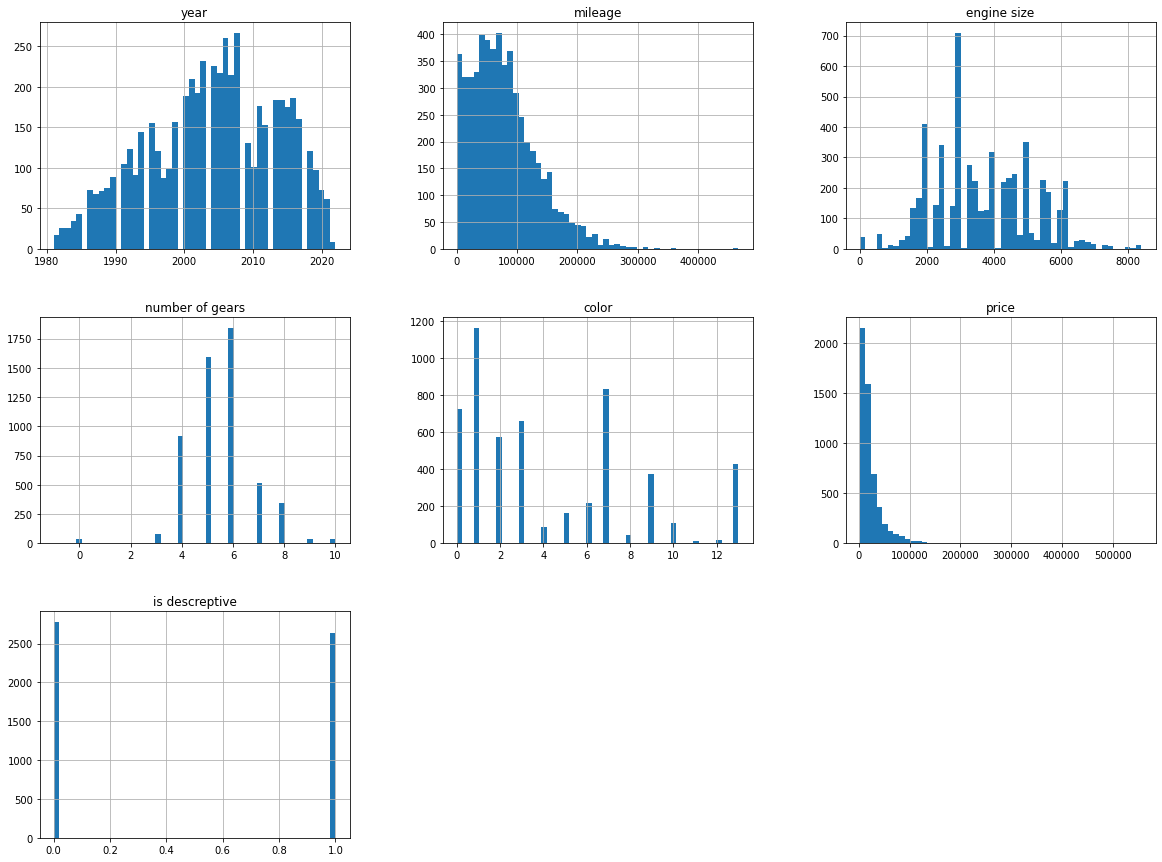

In [17]:
df.hist(bins=50, figsize=(20,15))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5419 entries, 0 to 5419
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   year               5419 non-null   int64 
 1   make               5419 non-null   object
 2   model              5419 non-null   object
 3   mileage            5419 non-null   int64 
 4   state of origin    5419 non-null   object
 5   engine size        5419 non-null   int64 
 6   engine type        5419 non-null   object
 7   drivetrain         5419 non-null   object
 8   transmmision type  5419 non-null   object
 9   number of gears    5419 non-null   int64 
 10  body_style         5419 non-null   object
 11  color              5419 non-null   int64 
 12  price              5419 non-null   int64 
 13  is descreptive     5419 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 635.0+ KB


In [19]:
df = df.drop(df.loc[(df["price"] > 100000)].index)
df = df.drop(df.loc[(df["mileage"] > 300000)].index)

In [20]:
df = df.drop(df[df.groupby('make')['make'].transform('size') < 5].index)

In [21]:
cars_df_with_dummies = pd.get_dummies(df)

In [22]:
std_scaler = StandardScaler()

price_label = cars_df_with_dummies['price']
cars_without_price = cars_df_with_dummies.drop(['price'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(cars_without_price,price_label,test_size=0.2,random_state=0)


X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)



In [23]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
initial_prediction = linear_reg.predict(X_test)


print(linear_reg.score(X_test,y_test))
print (mean_squared_error(y_test,initial_prediction))

-1.1385284983043954e+26
3.6196221046685027e+34


In [24]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
initial_prediction = knn_reg.predict(X_test)


print(knn_reg.score(X_test,y_test))
print (mean_squared_error(y_test,initial_prediction))

0.5022215194336099
158254272.43760455


In [25]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
initial_prediction = rf_reg.predict(X_test)


print(rf_reg.score(X_test,y_test))
print (mean_squared_error(y_test,initial_prediction))

0.7886821617642107
67182395.4804973
